In [1]:
!pip install sentence-transformers matplotlib scikit-learn
!pip install spacy gensim nltk pyLDAvis
!pip install "numpy<2.0" --upgrade --force-reinstall
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.7 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of gensim to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 26.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.7/635.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.5/848.5 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 12.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 60.6 MB/s et

In [2]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import ConvexHull
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string

/Users/yume/PycharmProjects/semantic_horizons/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/yume/PycharmProjects/semantic_horizons/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/yume/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yume/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Load a sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')  # small but high-quality model

## acutual polished pipeline 

In [4]:
try:
    from umap import UMAP
    has_umap = True
except ImportError:
    has_umap = False

In [6]:
import seaborn as sns
import plotly.graph_objects as go
#takes in filepath, creates embeddings based on specified model 
def embed_sentences_from_txt(file_path, model=None):
    if model is None:
        model = SentenceTransformer('all-MiniLM-L6-v2')
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    sentences = [s.strip() for s in sent_tokenize(text) if len(s.strip().split()) > 1]
    embeddings = model.encode(sentences)
    return sentences, embeddings


def plot_2d_scatter(embeddings, labels, method="PCA", title=""):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, perplexity=10, random_state=42)
    else:
        raise ValueError("Unsupported method")

    reduced = reducer.fit_transform(embeddings)

    fig = go.Figure()

    for group, color in zip(['Novice', 'Expert'], ['Blues', 'Reds']):
        idxs = [i for i, l in enumerate(labels) if l == group]
        x = reduced[idxs, 0]
        y = reduced[idxs, 1]
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='markers+lines',
            line=dict(width=1, color='lightgrey'),
            marker=dict(
                size=8,
                color=np.linspace(0.3, 1.0, len(x)),
                colorscale=color,
                showscale=False
            ),
            name=group,
            hovertext=[f"{group} - Step {i}" for i in range(len(x))],
            hoverinfo="text"
        ))

    fig.update_layout(
        title=title,
        xaxis_title=f"{method} Dimension 1",
        yaxis_title=f"{method} Dimension 2",
        width=1000,
        height=700
    )
    fig.show()

def plot_cosine_heatmap(embeddings, sentences):
    sim_matrix = cosine_similarity(embeddings)
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, cmap="viridis")
    plt.title("Cosine Similarity Heatmap")
    plt.xlabel("Sentence Index")
    plt.ylabel("Sentence Index")
    plt.show()


#a is novice, b is expert
def compute_stats(emb_a, emb_b):
    centroid_a = np.mean(emb_a, axis=0)
    centroid_b = np.mean(emb_b, axis=0)
    dist_euclidean = np.linalg.norm(centroid_a - centroid_b)
    dist_cosine = 1 - cosine_similarity([centroid_a], [centroid_b])[0][0]

    stats = {
        "Centroid Distance (Euclidean)": dist_euclidean,
        "Centroid Distance (Cosine)": dist_cosine
    }

    # Average pairwise cosine similarity
    def avg_pairwise_cosine(emb):
        if len(emb) < 2:
            return "Insufficient data"
        sim_matrix = cosine_similarity(emb)
        n = len(emb)
        upper_triangle = sim_matrix[np.triu_indices(n, k=1)]
        return np.mean(upper_triangle)

    stats["Avg Cosine Similarity (Novice)"] = avg_pairwise_cosine(emb_a)
    stats["Avg Cosine Similarity (Expert)"] = avg_pairwise_cosine(emb_b)

    # Average distance to centroid
    stats["Avg Dist to Centroid (Novice)"] = np.mean([np.linalg.norm(vec - centroid_a) for vec in emb_a])
    stats["Avg Dist to Centroid (Expert)"] = np.mean([np.linalg.norm(vec - centroid_b) for vec in emb_b])

    # Convex hull area in 2D PCA space
    try:
        if len(emb_a) >= 3:
            hull_a = ConvexHull(PCA(n_components=2).fit_transform(emb_a))
            stats["Convex Hull Area (Novice)"] = hull_a.volume
        else:
            stats["Convex Hull Area (Novice)"] = "Insufficient data"

        if len(emb_b) >= 3:
            hull_b = ConvexHull(PCA(n_components=2).fit_transform(emb_b))
            stats["Convex Hull Area (Expert)"] = hull_b.volume
        else:
            stats["Convex Hull Area (Expert)"] = "Insufficient data"
    except:
        stats["Convex Hull Error"] = "Unable to compute"

    return stats



import numbers

def sanitize_stats(stats_dict):
    cleaned_stats = {}
    for k, v in stats_dict.items():
        # Handle arrays or 0-D tensors
        if isinstance(v, (np.ndarray, list)) and np.array(v).size == 1:
            v = np.array(v).item()
        # Replace anything that's not a scalar (like arrays) with string fallback
        if isinstance(v, numbers.Number):
            if np.isnan(v) or np.isinf(v):
                cleaned_stats[k] = np.nan
            else:
                cleaned_stats[k] = v
        else:
            try:
                cleaned_stats[k] = float(v)
            except:
                cleaned_stats[k] = np.nan
    return cleaned_stats


import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, distance_matrix
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture


# a is novice b is expert
def compute_extended_stats(emb_a, emb_b):
    stats = {}

    # Combine and prepare
    all_embeddings = np.vstack([emb_a, emb_b])
    labels = ['Novice'] * len(emb_a) + ['Expert'] * len(emb_b)

    # Centroids and distances
    centroid_a = np.mean(emb_a, axis=0)
    centroid_b = np.mean(emb_b, axis=0)
    stats["Centroid Distance (Euclidean)"] = np.linalg.norm(centroid_a - centroid_b)
    stats["Centroid Distance (Cosine)"] = 1 - cosine_similarity([centroid_a], [centroid_b])[0][0]

    # Average pairwise cosine similarity
    def avg_pairwise_cosine(emb):
        if len(emb) < 2:
            return np.nan
        sim_matrix = cosine_similarity(emb)
        return np.mean(sim_matrix[np.triu_indices(len(emb), k=1)])

    stats["Avg Cosine Similarity (Novice)"] = avg_pairwise_cosine(emb_a)
    stats["Avg Cosine Similarity (Expert)"] = avg_pairwise_cosine(emb_b)

    # Avg distance to centroid
    stats["Avg Dist to Centroid (Novice)"] = np.mean(np.linalg.norm(emb_a - centroid_a, axis=1))
    stats["Avg Dist to Centroid (Expert)"] = np.mean(np.linalg.norm(emb_b - centroid_b, axis=1))

    # PCA Explained Variance
    pca_full = PCA()
    pca_full.fit(all_embeddings)
    stats["PCA Explained Variance Ratio (1st)"] = pca_full.explained_variance_ratio_[0]
    stats["PCA Components > 95% Variance"] = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.95) + 1

    # Convex Hull in PCA 2D
    try:
        pca_2d = PCA(n_components=2)
        emb_a_2d = pca_2d.fit_transform(emb_a)
        emb_b_2d = pca_2d.fit_transform(emb_b)
        stats["Convex Hull Area (Novice)"] = ConvexHull(emb_a_2d).volume if len(emb_a) >= 3 else np.nan
        stats["Convex Hull Area (Expert)"] = ConvexHull(emb_b_2d).volume if len(emb_b) >= 3 else np.nan
    except:
        stats["Convex Hull Area (Novice)"] = np.nan
        stats["Convex Hull Area (Expert)"] = np.nan

    # Pairwise intra-cluster distances
    def intra_cluster_dists(emb):
        dists = distance_matrix(emb, emb)
        triu_vals = dists[np.triu_indices(len(emb), k=1)]
        return np.mean(triu_vals), np.std(triu_vals)

    intra_nov_mean, intra_nov_std = intra_cluster_dists(emb_a)
    intra_exp_mean, intra_exp_std = intra_cluster_dists(emb_b)

    stats["Intra-cluster Distance Mean (Novice)"] = intra_nov_mean
    stats["Intra-cluster Distance Std (Novice)"] = intra_nov_std
    stats["Intra-cluster Distance Mean (Expert)"] = intra_exp_mean
    stats["Intra-cluster Distance Std (Expert)"] = intra_exp_std

    # Inter-cluster distance
    inter_dists = distance_matrix(emb_a, emb_b)
    stats["Inter-cluster Distance Mean"] = np.mean(inter_dists)

    # KL Divergence using Gaussian Mixture Approximation
    try:
        gmm_nov = GaussianMixture(n_components=1, covariance_type='full').fit(emb_a)
        gmm_exp = GaussianMixture(n_components=1, covariance_type='full').fit(emb_b)
        sample_nov = gmm_nov.sample(1000)[0]
        log_p = gmm_nov.score_samples(sample_nov)
        log_q = gmm_exp.score_samples(sample_nov)
        log_p = np.clip(log_p, -700, 700)
        log_q = np.clip(log_q, -700, 700)
        p = np.exp(log_p)
        q = np.exp(log_q)
        p /= np.sum(p)
        q /= np.sum(q)
        stats["KL Divergence (Novice || Expert)"] = entropy(p, q)


        
    except:
        stats["KL Divergence (Novice || Expert)"] = np.nan

    # Spectral Entropy of distance matrix
    try:
        dist_mat = distance_matrix(all_embeddings, all_embeddings)
        eigvals = np.linalg.eigvalsh(dist_mat)
        norm_eigvals = np.abs(eigvals / np.sum(np.abs(eigvals)))
        stats["Spectral Entropy"] = entropy(norm_eigvals)
    except:
        stats["Spectral Entropy"] = np.nan

    # Density Estimate via KDE
    for group_name, emb in zip(['Novice', 'Expert'], [emb_a, emb_b]):
        try:
            kde = KernelDensity(kernel='gaussian').fit(emb)
            log_density = kde.score_samples(emb)
            stats[f"KDE Mean Log Density ({group_name})"] = np.mean(log_density)
        except:
            stats[f"KDE Mean Log Density ({group_name})"] = np.nan

    

    return sanitize_stats(stats)





def analyze_text_embedding(novice_path, expert_path, topic):
    sentences_nov, emb_nov = embed_sentences_from_txt(novice_path)
    sentences_exp, emb_exp = embed_sentences_from_txt(expert_path)

    all_embeddings = np.vstack([emb_nov, emb_exp])
    all_sentences = sentences_nov + sentences_exp
    labels = ['Novice'] * len(emb_nov) + ['Expert'] * len(emb_exp)

    # Plots
    plot_2d_scatter(all_embeddings, labels, method="PCA", title=f"PCA: Expert vs Novice - {topic}")
    plot_2d_scatter(all_embeddings, labels, method="TSNE", title=f"t-SNE: Expert vs Novice - {topic}")
    plot_cosine_heatmap(all_embeddings, all_sentences)

    # Stats
    stats = compute_stats(emb_nov, emb_exp)
    print("\n--- Statistical Summary ---")
    for k, v in stats.items():
        print(f"{k}: {v}")

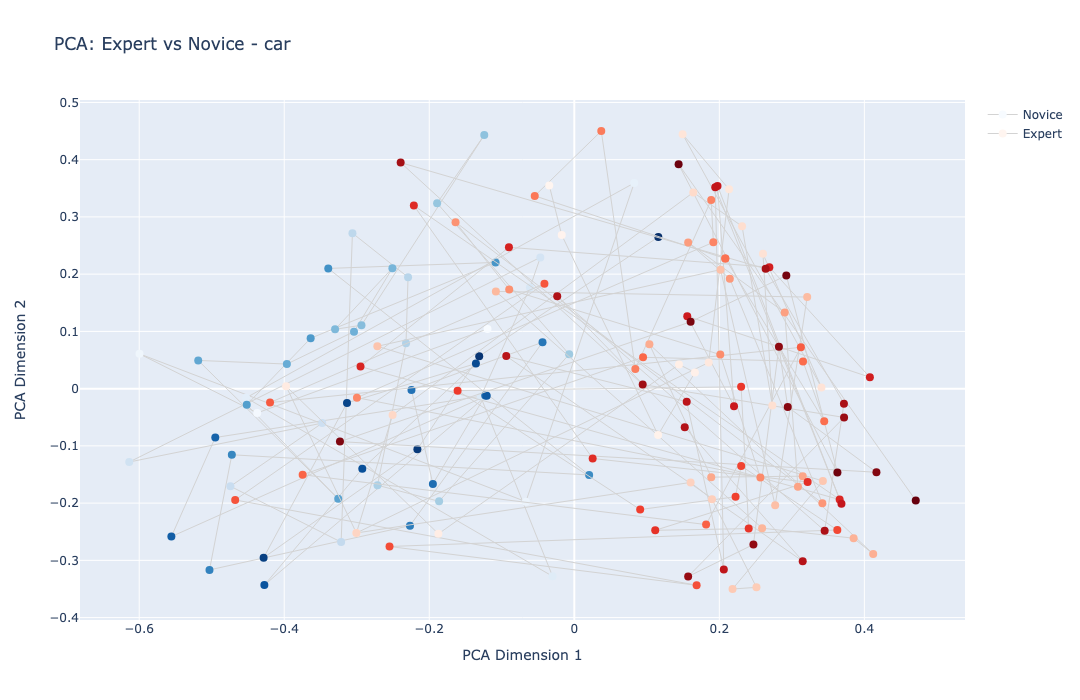

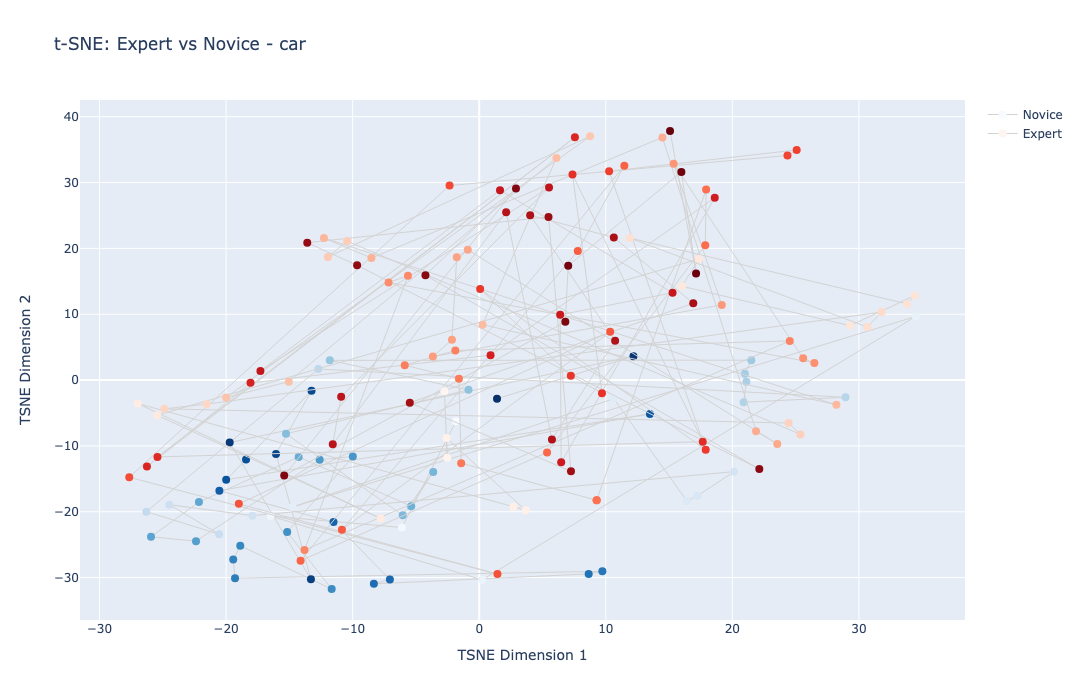

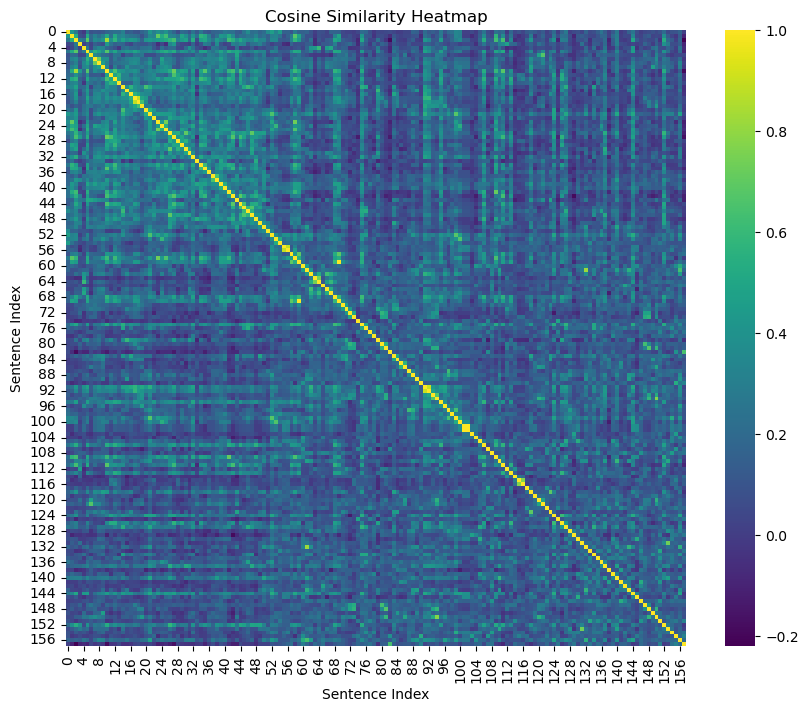


--- Statistical Summary ---
Centroid Distance (Euclidean): 0.4363434612751007
Centroid Distance (Cosine): 0.38333189487457275
Avg Cosine Similarity (Novice): 0.2826659679412842
Avg Cosine Similarity (Expert): 0.16640205681324005
Avg Dist to Centroid (Novice): 0.8358288407325745
Avg Dist to Centroid (Expert): 0.907751739025116
PCA Explained Variance Ratio (1st): 0.09216080605983734
PCA Components > 95% Variance: 90
Convex Hull Area (Novice): 0.6500982202839412
Convex Hull Area (Expert): 0.6116650598469873
Intra-cluster Distance Mean (Novice): 1.191421471739255
Intra-cluster Distance Std (Novice): 0.12321911097170007
Intra-cluster Distance Mean (Expert): 1.287174385155558
Intra-cluster Distance Std (Expert): 0.10187246224410575
Inter-cluster Distance Mean: 1.3070787502818895
KL Divergence (Novice || Expert): 0.0
Spectral Entropy: 3.0790930702319557
KDE Mean Log Density (Novice): -353.5617409921554
KDE Mean Log Density (Expert): -353.6869971404726


In [9]:
analyze_text_embedding("expert_generated.txt",
                       "novice_generated.txt", "car")


In [ ]:
# Global dataframe to collect all stats
stats_df = pd.DataFrame()

def collect_and_append_stats(expert_path, novice_path, topic):
    global stats_df

    # Embed and compute stats
    sentences_nov, emb_nov = embed_sentences_from_txt(novice_path)
    sentences_exp, emb_exp = embed_sentences_from_txt(expert_path)
    stats = compute_extended_stats(emb_nov, emb_exp)

    # Add topic and append to global dataframe
    stats["Topic"] = topic
    stats_df = pd.concat([stats_df, pd.DataFrame([stats])], ignore_index=True)


In [ ]:
collect_and_append_stats("great_decision_expert_full.txt",
                       "great_decision_novice_full.txt", "decision making")

collect_and_append_stats("good_creativity_expert_expanded.txt",
                       "good_creativity_novice_expanded.txt", "creativity")

collect_and_append_stats("good_nutrition_expert_expanded.txt",
                       "good_nutrition_novice_expanded.txt", "nutrition")

collect_and_append_stats("good_language_acquisition_novice_freespeech.txt",
                       "good_language_acquisition_expert_freespeech.txt", "language acquisition")

collect_and_append_stats("climate_expert_full.txt",
                       "climate_novice_full.txt", "climate")

collect_and_append_stats("vision_expert_full.txt",
                       "vision_novice_full.txt", "vision")

In [ ]:
stats_df

In [13]:
collect_and_append_stats("ai_expert_refined.txt",
                       "ai_novice_refined.txt", "AI")

collect_and_append_stats("memory_expert.txt",
                       "memory_novice.txt", "memory")

collect_and_append_stats("time_expert.txt",
                       "time_novice.txt", "time")



In [14]:
stats_df

,Centroid Distance (Euclidean),Centroid Distance (Cosine),Avg Cosine Similarity (Novice),Avg Cosine Similarity (Expert),Avg Dist to Centroid (Novice),Avg Dist to Centroid (Expert),PCA Explained Variance Ratio (1st),PCA Components > 95% Variance,Convex Hull Area (Novice),Convex Hull Area (Expert),Intra-cluster Distance Mean (Novice),Intra-cluster Distance Std (Novice),Intra-cluster Distance Mean (Expert),Intra-cluster Distance Std (Expert),Inter-cluster Distance Mean,KL Divergence (Novice || Expert),Spectral Entropy,KDE Mean Log Density (Novice),KDE Mean Log Density (Expert),Topic
0,0.368802,0.241387,0.243386,0.263722,0.848866,0.839989,0.082863,42,0.633201,0.705120,1.223695,0.125696,1.209877,0.093565,1.250215,0.0,2.632256,-353.580624,-353.564525,decision making
1,0.404230,0.195069,0.411724,0.350017,0.737093,0.779598,0.119892,30,0.748832,0.548852,1.074280,0.149911,1.132718,0.130062,1.147310,0.0,2.437672,-353.409199,-353.468351,creativity
2,0.386157,0.234890,0.273316,0.302696,0.829539,0.813893,0.102860,39,0.694310,0.732719,1.199135,0.124271,1.173829,0.129354,1.225425,0.0,2.586037,-353.548516,-353.523945,nutrition
3,0.307311,0.179483,0.230105,0.226523,0.855964,0.853122,0.112125,37,0.545050,0.695231,1.235238,0.118222,1.237180,0.127824,1.246767,0.0,2.542845,-353.590129,-353.581175,language acquisition
4,0.319625,0.200590,0.187319,0.245271,0.879869,0.849694,0.102581,39,0.671113,0.683092,1.270484,0.105978,1.224510,0.100164,1.262741,0.0,2.574360,-353.625278,-353.577265,climate
5,0.330725,0.151666,0.341814,0.312726,0.787152,0.804015,0.086392,34,0.655250,0.692103,1.141048,0.119924,1.166842,0.114136,1.173768,0.0,2.511376,-353.483522,-353.505740,vision
6,0.424083,0.277903,0.237824,0.291824,0.830828,0.809939,0.128472,22,0.672676,0.532731,1.226880,0.138266,1.187519,0.078435,1.234728,0.0,2.274094,-353.534936,-353.506282,AI
7,0.334863,0.125817,0.332250,0.439671,0.780157,0.721012,0.121534,25,0.723378,0.607493,1.146479,0.145214,1.052610,0.112566,1.113112,0.0,2.338488,-353.466206,-353.382072,memory
8,0.310355,0.103599,0.401556,0.443887,0.739124,0.710946,0.114561,24,0.722871,0.481610,1.084411,0.144711,1.042940,0.156528,1.072134,0.0,2.328580,-353.410405,-353.372551,time


In [15]:
collect_and_append_stats("robotics_expert.txt",
                       "robotics_novice.txt", "robotics")

collect_and_append_stats("mental_expert.txt",
                       "mental_novice.txt", "mental health")

collect_and_append_stats("mind_expert.txt",
                       "mind_novice.txt", "mind")

collect_and_append_stats("moral_expert.txt",
                       "moral_novice.txt", "morals")

collect_and_append_stats("language_expert.txt",
                       "language_novice.txt", "language")



In [16]:
stats_df

,Centroid Distance (Euclidean),Centroid Distance (Cosine),Avg Cosine Similarity (Novice),Avg Cosine Similarity (Expert),Avg Dist to Centroid (Novice),Avg Dist to Centroid (Expert),PCA Explained Variance Ratio (1st),PCA Components > 95% Variance,Convex Hull Area (Novice),Convex Hull Area (Expert),Intra-cluster Distance Mean (Novice),Intra-cluster Distance Std (Novice),Intra-cluster Distance Mean (Expert),Intra-cluster Distance Std (Expert),Inter-cluster Distance Mean,KL Divergence (Novice || Expert),Spectral Entropy,KDE Mean Log Density (Novice),KDE Mean Log Density (Expert),Topic
0,0.368802,0.241387,0.243386,0.263722,0.848866,0.839989,0.082863,42,0.633201,0.705120,1.223695,0.125696,1.209877,0.093565,1.250215,0.0,2.632256,-353.580624,-353.564525,decision making
1,0.404230,0.195069,0.411724,0.350017,0.737093,0.779598,0.119892,30,0.748832,0.548852,1.074280,0.149911,1.132718,0.130062,1.147310,0.0,2.437672,-353.409199,-353.468351,creativity
2,0.386157,0.234890,0.273316,0.302696,0.829539,0.813893,0.102860,39,0.694310,0.732719,1.199135,0.124271,1.173829,0.129354,1.225425,0.0,2.586037,-353.548516,-353.523945,nutrition
3,0.307311,0.179483,0.230105,0.226523,0.855964,0.853122,0.112125,37,0.545050,0.695231,1.235238,0.118222,1.237180,0.127824,1.246767,0.0,2.542845,-353.590129,-353.581175,language acquisition
4,0.319625,0.200590,0.187319,0.245271,0.879869,0.849694,0.102581,39,0.671113,0.683092,1.270484,0.105978,1.224510,0.100164,1.262741,0.0,2.574360,-353.625278,-353.577265,climate
5,0.330725,0.151666,0.341814,0.312726,0.787152,0.804015,0.086392,34,0.655250,0.692103,1.141048,0.119924,1.166842,0.114136,1.173768,0.0,2.511376,-353.483522,-353.505740,vision
6,0.424083,0.277903,0.237824,0.291824,0.830828,0.809939,0.128472,22,0.672676,0.532731,1.226880,0.138266,1.187519,0.078435,1.234728,0.0,2.274094,-353.534936,-353.506282,AI
7,0.334863,0.125817,0.332250,0.439671,0.780157,0.721012,0.121534,25,0.723378,0.607493,1.146479,0.145214,1.052610,0.112566,1.113112,0.0,2.338488,-353.466206,-353.382072,memory
8,0.310355,0.103599,0.401556,0.443887,0.739124,0.710946,0.114561,24,0.722871,0.481610,1.084411,0.144711,1.042940,0.156528,1.072134,0.0,2.328580,-353.410405,-353.372551,time
9,0.360291,0.178216,0.326822,0.298126,0.779444,0.807662,0.119069,24,0.599649,0.698778,1.152535,0.134235,1.178451,0.122472,1.179090,0.0,2.328838,-353.461794,-353.509646,robotics
